<a href="https://colab.research.google.com/github/MuhammadAttaUrRehman/Echo-Mobile-Assistant/blob/main/FacebookNoiseDenoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install noisereduce numpy librosa soundfile tensorflow


In [ ]:

!pip install torch torchaudio librosa scipy numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:

import tensorflow as tf
import numpy as np
import librosa
import soundfile as sf
import scipy.io.wavfile
import IPython.display as ipd
import os
from google.colab import files
from kaggle.api.kaggle_api_extended import KaggleApi
import subprocess

class AudioDenoiser:
    def __init__(self, sample_rate=16000, duration=1.024, n_fft=512, hop_length=160):
        self.sample_rate = sample_rate
        self.duration = duration
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.target_length = int(sample_rate * duration)
        self.interpreter = None
        self.input_details = None
        self.output_details = None
        self.spec_stats = {'y_min': 0.0, 'y_max': 1.0}  # From your training output

    def load_tflite_model(self, model_path="denoising_model.tflite"):
        """Load the TFLite model"""
        try:
            self.interpreter = tf.lite.Interpreter(model_path=model_path)
            self.interpreter.allocate_tensors()
            self.input_details = self.interpreter.get_input_details()
            self.output_details = self.interpreter.get_output_details()
            print("TFLite model loaded successfully")
            print(f"Input shape: {self.input_details[0]['shape']}")
            print(f"Output shape: {self.output_details[0]['shape']}")
        except Exception as e:
            print(f"Error loading TFLite model: {e}")
            return False
        return True

    def audio_to_spectrogram(self, audio):
        """Convert audio to magnitude spectrogram with phase preservation"""
        stft = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length)
        magnitude = np.abs(stft)
        phase = np.angle(stft)
        magnitude = np.log1p(magnitude)
        magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-8)
        return magnitude[..., np.newaxis], phase

    def convert_audio_to_wav(self, input_path, output_path):
        """Convert input audio (e.g., .aac) to .wav format"""
        try:
            # Use ffmpeg to convert (available in Colab)
            subprocess.run(['ffmpeg', '-i', input_path, '-ar', str(self.sample_rate), '-ac', '1', output_path, '-y'], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(f"Converted {input_path} to {output_path}")
            return output_path
        except Exception as e:
            print(f"Error converting audio: {e}")
            return None

    def denoise_audio(self, audio_file_path, output_path="denoised_output.wav"):
        """Denoise a single audio file using the TFLite model with debugging"""
        if self.interpreter is None:
            print("Error: TFLite model not loaded. Please upload or train a model.")
            return None

        # Convert audio to WAV if not already
        if not audio_file_path.lower().endswith('.wav'):
            wav_path = audio_file_path.replace('.aac', '_converted.wav')
            converted_path = self.convert_audio_to_wav(audio_file_path, wav_path)
            if converted_path:
                audio_file_path = converted_path
            else:
                print("Failed to convert audio. Please upload a .wav file.")
                return None

        # Load audio
        try:
            audio, sr = librosa.load(audio_file_path, sr=self.sample_rate, mono=True)
        except Exception as e:
            print(f"Error loading audio: {e}")
            return None

        # Pad or trim to target length
        if len(audio) < self.target_length:
            audio = np.pad(audio, (0, self.target_length - len(audio)), mode='constant')
        else:
            audio = audio[:self.target_length]
        print(f"Input audio shape: {audio.shape}")

        # Convert to spectrogram
        spec, phase = self.audio_to_spectrogram(audio)
        spec_input = spec[np.newaxis, ...].astype(np.float32)
        print(f"Spectrogram input shape: {spec_input.shape}")

        # Run TFLite inference
        self.interpreter.set_tensor(self.input_details[0]['index'], spec_input)
        self.interpreter.invoke()
        denoised_spec = self.interpreter.get_tensor(self.output_details[0]['index'])
        print(f"Denoised spectrogram shape: {denoised_spec.shape}")
        print(f"Denoised spectrogram min/max: {np.min(denoised_spec)}, {np.max(denoised_spec)}")

        # Denormalize and reconstruct audio
        denoised_spec = denoised_spec.squeeze()  # Remove all singleton dimensions
        denoised_spec = np.clip(denoised_spec, 0, 1)  # Sigmoid output range
        denoised_spec = denoised_spec * (self.spec_stats['y_max'] - self.spec_stats['y_min']) + self.spec_stats['y_min']
        denoised_spec = np.expm1(denoised_spec)
        denoised_spec = np.abs(denoised_spec)
        print(f"Denormalized spectrogram shape: {denoised_spec.shape}")

        # Ensure shape matches for ISTFT
        if denoised_spec.shape != spec.shape[:-1]:
            print(f"Shape mismatch: denoised_spec {denoised_spec.shape} vs input spec {spec.shape[:-1]}")
            target_shape = spec.shape[:-1]
            if denoised_spec.ndim == 2 and target_shape[0] == denoised_spec.shape[0] and target_shape[1] == denoised_spec.shape[1]:
                pass  # Shapes already match
            else:
                # Reshape or pad to match
                if denoised_spec.ndim == 3:  # Remove extra dimension if present
                    denoised_spec = denoised_spec.squeeze()
                if denoised_spec.shape[0] != target_shape[0] or denoised_spec.shape[1] != target_shape[1]:
                    pad_height = max(0, target_shape[0] - denoised_spec.shape[0])
                    pad_width = max(0, target_shape[1] - denoised_spec.shape[1])
                    denoised_spec = np.pad(denoised_spec, ((0, pad_height), (0, pad_width)), mode='constant')
                    denoised_spec = denoised_spec[:target_shape[0], :target_shape[1]]
        print(f"Adjusted denoised spectrogram shape: {denoised_spec.shape}")

        # Reconstruct complex STFT using input phase
        denoised_stft = denoised_spec * np.exp(1j * phase)
        denoised_audio = librosa.istft(denoised_stft, hop_length=self.hop_length, length=self.target_length)
        print(f"Reconstructed audio shape: {denoised_audio.shape}")

        # Debug: Check for invalid values
        if np.any(np.isnan(denoised_audio)) or np.any(np.isinf(denoised_audio)):
            print("Warning: Denoised audio contains NaN or infinite values, setting to zero.")
            denoised_audio = np.nan_to_num(denoised_audio, nan=0.0, posinf=0.0, neginf=0.0)

        # Amplify audio for better playback
        max_amplitude = np.max(np.abs(denoised_audio))
        if max_amplitude > 0:
            denoised_audio = denoised_audio / max_amplitude * 0.9  # Scale to 90% to avoid clipping
        print(f"Max amplitude after scaling: {np.max(np.abs(denoised_audio))}")

        # Save audio with fallback
        try:
            sf.write(output_path, denoised_audio, self.sample_rate, subtype='PCM_16')
            print(f"Denoised audio saved to {output_path} with soundfile")
        except Exception as e:
            print(f"Error saving with soundfile: {e}")
            try:
                scipy.io.wavfile.write(output_path.replace('.wav', '_scipy.wav'), self.sample_rate, (denoised_audio * 32767).astype(np.int16))
                print(f"Denoised audio saved to {output_path.replace('.wav', '_scipy.wav')} with scipy")
            except Exception as e2:
                print(f"Error saving with scipy: {e2}")

        # Verify and play audio
        try:
            ipd.display(ipd.Audio(output_path, rate=self.sample_rate))
            print(f"Denoised audio played successfully from {output_path}")
        except Exception as e:
            try:
                ipd.display(ipd.Audio(output_path.replace('.wav', '_scipy.wav'), rate=self.sample_rate))
                print(f"Denoised audio played successfully from {output_path.replace('.wav', '_scipy.wav')}")
            except Exception as e2:
                print(f"Error playing audio: {e2}")

        return denoised_audio

    def retrain_model(self, dataset_path, n_samples=100, epochs=20, batch_size=16):
        """Retrain a new model with 100 samples if the pre-trained one fails"""
        print(f"Retraining a new model with {n_samples} samples due to pre-trained model issues...")
        X_audio, Y_audio = self.load_dataset(dataset_path, n_samples)
        X_spec, Y_spec = self.prepare_data(X_audio, Y_audio)
        input_shape = X_spec.shape[1:]
        self.model = self.build_model(input_shape)
        history = self.train(X_spec, Y_spec, epochs, batch_size)
        self.convert_to_tflite("retrained_denoising_model.tflite")
        self.load_tflite_model("retrained_denoising_model.tflite")  # Load the new model
        return self.model

    def load_dataset(self, dataset_path, n_samples=100):
        """Load and preprocess dataset with limited samples"""
        X, Y = [], []
        audio_files = [os.path.join(root, file) for root, _, files in os.walk(dataset_path) for file in files if file.endswith('.wav')]
        print(f"Found {len(audio_files)} audio files, using {n_samples}")

        for i in range(min(n_samples, len(audio_files))):
            try:
                clean_audio, sr = librosa.load(audio_files[i], sr=self.sample_rate)
                if len(clean_audio) < self.target_length:
                    clean_audio = np.pad(clean_audio, (0, self.target_length - len(clean_audio)), mode='constant')
                else:
                    clean_audio = clean_audio[:self.target_length]
                noise = np.random.normal(0, 0.1, len(clean_audio))
                noisy_audio = clean_audio + noise
                X.append(noisy_audio)
                Y.append(clean_audio)
            except Exception as e:
                print(f"Error processing {audio_files[i]}: {e}")
                continue
        return np.array(X), np.array(Y)

    def prepare_data(self, X_audio, Y_audio):
        """Convert audio data to spectrograms"""
        X_spec, Y_spec = [], []
        for i, (x, y) in enumerate(zip(X_audio, Y_audio)):
            if i % 20 == 0:  # Reduced frequency for 100 samples
                print(f"Processed {i}/{len(X_audio)} samples")
            x_mag, _ = self.audio_to_spectrogram(x)
            y_mag, _ = self.audio_to_spectrogram(y)
            X_spec.append(x_mag)
            Y_spec.append(y_mag)
        X_spec = np.array(X_spec)
        Y_spec = np.array(Y_spec)
        self.spec_stats = {
            'y_min': np.min(Y_spec),
            'y_max': np.max(Y_spec),
            'x_min': np.min(X_spec),
            'x_max': np.max(X_spec)
        }
        return X_spec, Y_spec

    def build_model(self, input_shape):
        """Build a simple denoising model"""
        inputs = layers.Input(shape=input_shape)
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        if x.shape[1] != input_shape[0] or x.shape[2] != input_shape[1]:
            crop_h = x.shape[1] - input_shape[0]
            crop_w = x.shape[2] - input_shape[1]
            if crop_h > 0 or crop_w > 0:
                x = layers.Cropping2D(cropping=((crop_h//2, crop_h-crop_h//2), (crop_w//2, crop_w-crop_w//2)))(x)
        outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
        model = models.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def train(self, X_spec, Y_spec, epochs=20, batch_size=16):
        """Train the model"""
        history = self.model.fit(X_spec, Y_spec, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
        return history

    def convert_to_tflite(self, model_path="retrained_denoising_model.tflite"):
        """Convert model to TFLite"""
        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()
        with open(model_path, "wb") as f:
            f.write(tflite_model)
        print(f"TFLite model saved to {model_path}")
        return tflite_model

# Example usage
def main():
    denoiser = AudioDenoiser()

    # Upload the pre-trained TFLite model
    print("Please upload your pre-trained denoising_model.tflite (optional, skip if retraining):")
    uploaded_models = files.upload()
    if "denoising_model.tflite" in uploaded_models:
        if not denoiser.load_tflite_model("denoising_model.tflite"):
            print("Failed to load pre-trained model. Proceeding to retrain...")
            # Download dataset for retraining
            dataset_path = "/content/mini_speech_commands"
            if not os.path.exists(dataset_path):
                print("Downloading Mini Speech Commands dataset...")
                !pip install -q kaggle
                uploaded = files.upload()  # Upload kaggle.json
                for fn in uploaded.keys():
                    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
                !mkdir -p ~/.kaggle
                !mv kaggle.json ~/.kaggle/
                !chmod 600 ~/.kaggle/kaggle.json
                !kaggle datasets download -d antfilatov/mini-speech-commands -p /content --unzip
                print(f"Downloaded and extracted to {dataset_path}")
            denoiser.retrain_model(dataset_path, n_samples=100)
    else:
        print("No pre-trained model uploaded. Proceeding to retrain...")
        dataset_path = "/content/mini_speech_commands"
        if not os.path.exists(dataset_path):
            print("Downloading Mini Speech Commands dataset...")
            !pip install -q kaggle
            uploaded = files.upload()  # Upload kaggle.json
            for fn in uploaded.keys():
                print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
            !kaggle datasets download -d antfilatov/mini-speech-commands -p /content --unzip
            print(f"Downloaded and extracted to {dataset_path}")
        denoiser.retrain_model(dataset_path, n_samples=100)

    # Upload custom audio file
    print("Please upload your audio file (WAV or AAC format, 16 kHz mono recommended):")
    uploaded_audio = files.upload()
    audio_file = list(uploaded_audio.keys())[0]
    print(f"Uploaded file: {audio_file}")

    # Denoise the audio
    denoised_audio = denoiser.denoise_audio(audio_file)

    # Download the denoised WAV file
    if denoised_audio is not None:
        output_path = "denoised_output_scipy.wav" if os.path.exists("denoised_output_scipy.wav") else "denoised_output.wav"
        try:
            files.download(output_path)
            print(f"Downloaded {output_path} for local verification")
        except Exception as e:
            print(f"Error downloading file: {e}")

if __name__ == "__main__":
    main()

Please upload your pre-trained denoising_model.tflite (optional, skip if retraining):


No pre-trained model uploaded. Proceeding to retrain...
Retraining a new model with 100 samples due to pre-trained model issues...
Found 8000 audio files, using 100
Processed 0/100 samples
Processed 20/100 samples
Processed 40/100 samples
Processed 60/100 samples
Processed 80/100 samples
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 820ms/step - loss: 0.2128 - mae: 0.4580 - val_loss: 0.1637 - val_mae: 0.4008
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.1438 - mae: 0.3743 - val_loss: 0.0815 - val_mae: 0.2787
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 746ms/step - loss: 0.0675 - mae: 0.2465 - val_loss: 0.0205 - val_mae: 0.1236
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step - loss: 0.0146 - mae: 0.0971 - val_loss: 0.0070 - val_mae: 0.0423
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 953ms/step - loss: 0.0057 - mae: 0.0347 - val_loss: 0.0058 - val_mae: 0.0241
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 715ms/step - loss: 0.0047 - mae: 0.0204 - val_loss: 0.0057 - val_mae: 0.0207
Epoch 7/20
5/5 ━━━

Saving sample_audio.aac to sample_audio (3).aac
Uploaded file: sample_audio (3).aac
Converted sample_audio (3).aac to sample_audio (3)_converted.wav
Input audio shape: (16384,)
Spectrogram input shape: (1, 257, 103, 1)
Denoised spectrogram shape: (1, 257, 103, 1)
Denoised spectrogram min/max: 1.4332117714843662e-09, 0.3723883330821991
Denormalized spectrogram shape: (257, 103)
Adjusted denoised spectrogram shape: (257, 103)
Reconstructed audio shape: (16384,)
Max amplitude after scaling: 0.8999999761581421
Denoised audio saved to denoised_output.wav with soundfile


Denoised audio played successfully from denoised_output.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded denoised_output_scipy.wav for local verification


In [ ]:

import tensorflow as tf
import numpy as np
import librosa
import soundfile as sf
import scipy.io.wavfile
import IPython.display as ipd
import os
from google.colab import files

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="denoising_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Upload custom audio file
print("Please upload your audio file (WAV format, 16 kHz mono recommended):")
uploaded = files.upload()
audio_file = list(uploaded.keys())[0]
print(f"Uploaded file: {audio_file}")

# Load and preprocess the custom audio
sample_rate = 16000
target_length = int(sample_rate * 1.024)  # 16384 samples
input_audio, sr = librosa.load(audio_file, sr=sample_rate, mono=True)

# Pad or truncate to target length
if len(input_audio) < target_length:
    input_audio = np.pad(input_audio, (0, target_length - len(input_audio)), mode='constant')
else:
    input_audio = input_audio[:target_length]

# Preprocess audio to spectrogram (preserve phase)
def audio_to_spectrogram(audio, sample_rate=16000, n_fft=512, hop_length=160):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    phase = np.angle(stft)
    magnitude = np.log1p(magnitude)
    magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-8)
    return magnitude[..., np.newaxis], phase

input_spec, input_phase = audio_to_spectrogram(input_audio, n_fft=512, hop_length=160)
input_spec = input_spec[np.newaxis, ...].astype(np.float32)

# Run inference with TFLite model
interpreter.set_tensor(input_details[0]['index'], input_spec)
interpreter.invoke()
output_spec = interpreter.get_tensor(output_details[0]['index'])

# Denormalize and reconstruct audio
output_spec = output_spec.squeeze(-1)  # Remove channel dimension
output_spec = np.clip(output_spec, 0, 1)  # Sigmoid output range
y_spec_min, y_spec_max = 0.0, 1.0  # From your training output
output_spec = output_spec * (y_spec_max - y_spec_min) + y_spec_min  # Reverse normalization
output_spec = np.expm1(output_spec)  # Reverse log1p
output_spec = np.abs(output_spec)  # Ensure real-valued spectrogram

# Reconstruct complex STFT using input phase
output_stft = output_spec * np.exp(1j * input_phase)
output_audio = librosa.istft(output_stft, hop_length=160, length=target_length)

# Debug: Check for invalid values
if np.any(np.isnan(output_audio)) or np.any(np.isinf(output_audio)):
    print("Warning: Output audio contains NaN or infinite values, setting to zero.")
    output_audio = np.nan_to_num(output_audio, nan=0.0, posinf=0.0, neginf=0.0)

# Amplify audio for better playback
max_amplitude = np.max(np.abs(output_audio))
if max_amplitude > 0:
    output_audio = output_audio / max_amplitude * 0.9  # Scale to 90% to avoid clipping

# Save audio with fallback
try:
    sf.write("/content/denoised_output.wav", output_audio, sr, subtype='PCM_16')
    print("Denoised output saved to denoised_output.wav with soundfile")
except Exception as e:
    print(f"Error saving with soundfile: {e}")
    try:
        scipy.io.wavfile.write("/content/denoised_output_scipy.wav", sr, (output_audio * 32767).astype(np.int16))
        print("Denoised output saved to denoised_output_scipy.wav with scipy")
    except Exception as e2:
        print(f"Error saving with scipy: {e2}")

# Verify and play audio
try:
    ipd.display(ipd.Audio("/content/denoised_output_scipy.wav", rate=sr))
    print("Denoised audio played successfully from denoised_output.wav")
except Exception as e:
    try:
        ipd.display(ipd.Audio("/content/denoised_output_scipy.wav", rate=sr))
        print("Denoised audio played successfully from denoised_output_scipy.wav")
    except Exception as e2:
        print(f"Error playing audio: {e2}")

# Download the denoised WAV file
try:
    files.download("/content/denoised_output_scipy.wav")
    print("Downloaded denoised_output_scipy.wav for local verification")
except Exception as e:
    print(f"Error downloading file: {e}")


Please upload your audio file (WAV format, 16 kHz mono recommended):


Saving sample_audio.aac to sample_audio (1).aac
Uploaded file: sample_audio (1).aac
Error saving with soundfile: Error opening '/content/denoised_output.wav': Format not recognised.
Denoised output saved to denoised_output_scipy.wav with scipy


<ipython-input-21-1160255284>:25: UserWarning: PySoundFile failed. Trying audioread instead.
  input_audio, sr = librosa.load(audio_file, sr=sample_rate, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Denoised audio played successfully from denoised_output.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded denoised_output_scipy.wav for local verification


In [ ]:
import torch
import torch.nn as nn
import torchaudio
import numpy as np
import librosa
from scipy.io import wavfile
import os
import requests
from urllib.parse import urlparse

# Facebook's Denoiser Model (Pretrained)
class FacebookDenoiser:
    def __init__(self):
        """Load Facebook's pretrained denoiser model"""
        try:
            # Load pretrained Facebook denoiser
            self.model = torch.hub.load('facebookresearch/denoiser', 'dns64')
            self.model.eval()
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.model.to(self.device)
            print("✓ Facebook Denoiser model loaded successfully")
        except Exception as e:
            print(f"Error loading Facebook model: {e}")
            print("Falling back to alternative implementation...")
            self.model = None

    def enhance_audio(self, audio_path, output_path=None):
        """Enhance audio using Facebook's denoiser"""
        if self.model is None:
            print("Model not loaded properly")
            return None, None

        try:
            # Load audio
            wav, sr = torchaudio.load(audio_path)

            # Resample to 16kHz if needed (model expects 16kHz)
            if sr != 16000:
                resampler = torchaudio.transforms.Resample(sr, 16000)
                wav = resampler(wav)
                sr = 16000

            # Convert to mono if stereo
            if wav.shape[0] > 1:
                wav = wav.mean(dim=0, keepdim=True)

            # Move to device
            wav = wav.to(self.device)

            # Enhance audio
            with torch.no_grad():
                enhanced = self.model(wav.unsqueeze(0))
                enhanced = enhanced.squeeze(0).cpu()

            # Save enhanced audio
            if output_path is None:
                base_name = os.path.splitext(audio_path)[0]
                output_path = f"{base_name}_facebook_enhanced.wav"

            torchaudio.save(output_path, enhanced, sr)
            print(f"✓ Enhanced audio saved to: {output_path}")

            return enhanced.numpy(), sr

        except Exception as e:
            print(f"Error enhancing audio: {e}")
            return None, None

# Microsoft's DNS Challenge Model (Pretrained)
class MicrosoftDNSModel:
    def __init__(self):
        """Load Microsoft DNS Challenge pretrained model"""
        self.model_url = "https://github.com/microsoft/DNS-Challenge/releases/download/v4.0/dns4_baseline.tar.gz"
        self.model_path = "dns4_baseline.pth"

        if not os.path.exists(self.model_path):
            print("Downloading Microsoft DNS model...")
            self._download_model()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._load_dns_model()

    def _download_model(self):
        """Download Microsoft DNS model"""
        try:
            print("Note: This is a placeholder for Microsoft DNS model download")
            print("Please manually download the model from Microsoft DNS Challenge repository")
            # In practice, you would implement actual download logic here
        except Exception as e:
            print(f"Download failed: {e}")

    def _load_dns_model(self):
        """Load the DNS model architecture"""
        # This is a simplified version of the DNS model architecture
        class DNSModel(nn.Module):
            def __init__(self):
                super(DNSModel, self).__init__()
                self.encoder = nn.Sequential(
                    nn.Conv1d(1, 64, 15, padding=7),
                    nn.ReLU(),
                    nn.Conv1d(64, 128, 15, padding=7),
                    nn.ReLU(),
                    nn.Conv1d(128, 256, 15, padding=7),
                    nn.ReLU()
                )
                self.decoder = nn.Sequential(
                    nn.Conv1d(256, 128, 15, padding=7),
                    nn.ReLU(),
                    nn.Conv1d(128, 64, 15, padding=7),
                    nn.ReLU(),
                    nn.Conv1d(64, 1, 15, padding=7),
                    nn.Tanh()
                )

            def forward(self, x):
                encoded = self.encoder(x)
                decoded = self.decoder(encoded)
                return decoded

        model = DNSModel()
        if os.path.exists(self.model_path):
            try:
                model.load_state_dict(torch.load(self.model_path, map_location=self.device))
                print("✓ Microsoft DNS model loaded")
            except:
                print("⚠ Using randomly initialized weights (download real model for best results)")
        else:
            print("⚠ Using randomly initialized weights (download real model for best results)")

        model.eval()
        return model.to(self.device)

    def enhance_audio(self, audio_path, output_path=None):
        """Enhance audio using Microsoft DNS model"""
        try:
            # Load audio
            audio, sr = librosa.load(audio_path, sr=16000)

            # Convert to tensor
            audio_tensor = torch.FloatTensor(audio).unsqueeze(0).unsqueeze(0).to(self.device)

            # Enhance
            with torch.no_grad():
                enhanced = self.model(audio_tensor)
                enhanced = enhanced.squeeze().cpu().numpy()

            # Save
            if output_path is None:
                base_name = os.path.splitext(audio_path)[0]
                output_path = f"{base_name}_microsoft_enhanced.wav"

            wavfile.write(output_path, sr, (enhanced * 32767).astype(np.int16))
            print(f"✓ Enhanced audio saved to: {output_path}")

            return enhanced, sr

        except Exception as e:
            print(f"Error enhancing audio: {e}")
            return None, None

# Speechbrain's Pretrained Model
class SpeechBrainDenoiser:
    def __init__(self):
        """Load SpeechBrain's pretrained denoiser"""
        try:
            import speechbrain as sb
            from speechbrain.pretrained import SpectralMaskEnhancement

            self.model = SpectralMaskEnhancement.from_hparams(
                source="speechbrain/metricgan-plus-voicebank",
                savedir="pretrained_models/metricgan-plus-voicebank"
            )
            print("✓ SpeechBrain MetricGAN+ model loaded successfully")

        except ImportError:
            print("SpeechBrain not installed. Install with: pip install speechbrain")
            self.model = None
        except Exception as e:
            print(f"Error loading SpeechBrain model: {e}")
            self.model = None

    def enhance_audio(self, audio_path, output_path=None):
        """Enhance audio using SpeechBrain's model"""
        if self.model is None:
            print("SpeechBrain model not loaded")
            return None, None

        try:
            # Load and enhance audio
            enhanced = self.model.enhance_file(audio_path)

            # Save enhanced audio
            if output_path is None:
                base_name = os.path.splitext(audio_path)[0]
                output_path = f"{base_name}_speechbrain_enhanced.wav"

            torchaudio.save(output_path, enhanced.unsqueeze(0), 16000)
            print(f"✓ Enhanced audio saved to: {output_path}")

            return enhanced.numpy(), 16000

        except Exception as e:
            print(f"Error enhancing audio: {e}")
            return None, None

# Main Pretrained Noise Cancellation Manager
class PretrainedNoiseCancellation:
    def __init__(self):
        """Initialize all available pretrained models"""
        print("Loading pretrained noise cancellation models...")

        self.models = {}

        # Load Facebook Denoiser
        try:
            self.models['facebook'] = FacebookDenoiser()
        except Exception as e:
            print(f"Failed to load Facebook model: {e}")

        # Load Microsoft DNS
        try:
            self.models['microsoft'] = MicrosoftDNSModel()
        except Exception as e:
            print(f"Failed to load Microsoft model: {e}")

        # Load SpeechBrain
        try:
            self.models['speechbrain'] = SpeechBrainDenoiser()
        except Exception as e:
            print(f"Failed to load SpeechBrain model: {e}")

        print(f"✓ Loaded {len([m for m in self.models.values() if m is not None])} models")

    def list_models(self):
        """List available models"""
        available = [name for name, model in self.models.items() if model is not None]
        print("Available pretrained models:")
        for i, model_name in enumerate(available, 1):
            print(f"{i}. {model_name}")
        return available

    def enhance_audio(self, audio_path, model_name='facebook', output_path=None):
        """Enhance audio using specified pretrained model"""
        if model_name not in self.models:
            print(f"Model '{model_name}' not available")
            return None, None

        model = self.models[model_name]
        if model is None:
            print(f"Model '{model_name}' failed to load")
            return None, None

        print(f"Enhancing audio with {model_name} model...")
        return model.enhance_audio(audio_path, output_path)

    def compare_models(self, audio_path):
        """Compare all available models on the same audio file"""
        results = {}
        base_name = os.path.splitext(audio_path)[0]

        for model_name, model in self.models.items():
            if model is not None:
                output_path = f"{base_name}_{model_name}_enhanced.wav"
                enhanced, sr = model.enhance_audio(audio_path, output_path)
                results[model_name] = {'enhanced': enhanced, 'sr': sr, 'path': output_path}

        return results

# Example usage
if __name__ == "__main__":
    # Initialize pretrained models
    noise_canceller = PretrainedNoiseCancellation()

    # List available models
    noise_canceller.list_models()

    # Example audio file
    input_file = "noisy_audio.wav"

    if os.path.exists(input_file):
        # Enhance with Facebook model (default)
        enhanced_audio, sr = noise_canceller.enhance_audio(input_file, 'facebook')

        # Compare all models
        print("\nComparing all models...")
        results = noise_canceller.compare_models(input_file)

        print(f"\nProcessed with {len(results)} models:")
        for model_name, result in results.items():
            print(f"- {model_name}: {result['path']}")

    else:
        print(f"Input file {input_file} not found.")
        print("Please provide a valid audio file path.")

        # Example with custom file
        custom_file = input("Enter path to your audio file: ")
        if os.path.exists(custom_file):
            noise_canceller.enhance_audio(custom_file, 'facebook')

# Installation requirements for full functionality:
"""
pip install torch torchaudio librosa scipy numpy
pip install speechbrain  # for SpeechBrain model
"""

# Alternative: Simple function to use just Facebook's model
def quick_denoise(input_path, output_path=None):
    """Quick function to denoise audio using Facebook's pretrained model"""
    try:
        model = torch.hub.load('facebookresearch/denoiser', 'dns64')
        wav, sr = torchaudio.load(input_path)

        if sr != 16000:
            resampler = torchaudio.transforms.Resample(sr, 16000)
            wav = resampler(wav)
            sr = 16000

        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)

        with torch.no_grad():
            enhanced = model(wav.unsqueeze(0)).squeeze(0)

        if output_path is None:
            base_name = os.path.splitext(input_path)[0]
            output_path = f"{base_name}_denoised.wav"

        torchaudio.save(output_path, enhanced, sr)
        print(f"✓ Denoised audio saved to: {output_path}")
        return output_path

    except Exception as e:
        print(f"Error: {e}")
        return None

Loading pretrained noise cancellation models...


Downloading: "https://github.com/facebookresearch/denoiser/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/adiyoss/denoiser/dns64-a7761ff99a7d5bb6.th" to /root/.cache/torch/hub/checkpoints/dns64-a7761ff99a7d5bb6.th
100%|██████████| 128M/128M [00:01<00:00, 121MB/s]


✓ Facebook Denoiser model loaded successfully
Note: This is a placeholder for Microsoft DNS model download
Please manually download the model from Microsoft DNS Challenge repository
⚠ Using randomly initialized weights (download real model for best results)
SpeechBrain not installed. Install with: pip install speechbrain
✓ Loaded 3 models
Available pretrained models:
1. facebook
2. microsoft
3. speechbrain
Input file noisy_audio.wav not found.
Please provide a valid audio file path.
Enter path to your audio file: /content/sample_audio.aac
Enhancing audio with facebook model...
✓ Enhanced audio saved to: /content/sample_audio_facebook_enhanced.wav


In [ ]:
!pip install torch torchaudio torchvision
!pip install tensorflow
!pip install librosa
!pip install scipy
!pip install onnx
!pip install tf2onnx
!pip install soundfile

# Import required libraries
import tensorflow as tf
import torch
import torchaudio
import numpy as np
import librosa
import os
from scipy.io import wavfile
import soundfile as sf
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import IPython.display as ipd

print("✅ All packages installed successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 33.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: onnx
    Found existing installation: onnx 1.18.0
    Uninstalling onnx-1.18.0:
      Successfully uninstalled onnx-1.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.

✅ All packages installed successfully!
TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124


In [ ]:
import tensorflow as tf
import torch
import numpy as np
import librosa
import os
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd

class FacebookDenoiserTFLiteConverter:
    def __init__(self):
        self.pytorch_model = None
        self.tf_model = None
        self.sample_rate = 16000

    def load_facebook_denoiser(self):
        """Load Facebook's pretrained denoiser model"""
        try:
            print("📥 Loading Facebook Denoiser from PyTorch Hub...")
            # Load the DNS64 model (Facebook's denoiser)
            self.pytorch_model = torch.hub.load('facebookresearch/denoiser', 'dns64')
            self.pytorch_model.eval()
            print("✅ Facebook Denoiser loaded successfully!")
            return True
        except Exception as e:
            print(f"❌ Error loading Facebook model: {e}")
            print("🔄 Trying alternative loading method...")
            try:
                # Alternative loading method
                import torch.hub
                torch.hub.set_dir('/content/torch_cache')
                self.pytorch_model = torch.hub.load('facebookresearch/denoiser', 'dns64', force_reload=True)
                self.pytorch_model.eval()
                print("✅ Facebook Denoiser loaded successfully (alternative method)!")
                return True
            except Exception as e2:
                print(f"❌ Alternative loading also failed: {e2}")
                return False

    def create_tensorflow_equivalent(self, input_length=16000):
        """Create TensorFlow equivalent of Facebook's denoiser architecture with properly aligned dimensions"""
        print("🔧 Creating TensorFlow equivalent architecture...")

        # Fixed input length for consistent tensor shapes
        inputs = tf.keras.layers.Input(shape=(input_length,), name='audio_input', dtype=tf.float32)

        # Reshape for 1D convolutions
        x = tf.keras.layers.Reshape((input_length, 1))(inputs)

        # Encoder (downsampling path) - Properly aligned architecture
        # Layer 1: 16000 -> 8000
        conv1 = tf.keras.layers.Conv1D(64, 15, strides=1, padding='same', activation='relu', name='conv1')(x)
        conv1 = tf.keras.layers.BatchNormalization(name='bn1')(conv1)
        pool1 = tf.keras.layers.MaxPooling1D(2, name='pool1')(conv1)  # 8000

        # Layer 2: 8000 -> 4000
        conv2 = tf.keras.layers.Conv1D(128, 15, strides=1, padding='same', activation='relu', name='conv2')(pool1)
        conv2 = tf.keras.layers.BatchNormalization(name='bn2')(conv2)
        pool2 = tf.keras.layers.MaxPooling1D(2, name='pool2')(conv2)  # 4000

        # Layer 3: 4000 -> 2000
        conv3 = tf.keras.layers.Conv1D(256, 15, strides=1, padding='same', activation='relu', name='conv3')(pool2)
        conv3 = tf.keras.layers.BatchNormalization(name='bn3')(conv3)
        pool3 = tf.keras.layers.MaxPooling1D(2, name='pool3')(conv3)  # 2000

        # Layer 4: 2000 -> 1000
        conv4 = tf.keras.layers.Conv1D(512, 15, strides=1, padding='same', activation='relu', name='conv4')(pool3)
        conv4 = tf.keras.layers.BatchNormalization(name='bn4')(conv4)
        pool4 = tf.keras.layers.MaxPooling1D(2, name='pool4')(conv4)  # 1000

        # Bottleneck: 1000
        bottleneck = tf.keras.layers.Conv1D(1024, 15, strides=1, padding='same', activation='relu', name='bottleneck')(pool4)
        bottleneck = tf.keras.layers.BatchNormalization(name='bn_bottleneck')(bottleneck)

        # Decoder (upsampling path with properly aligned skip connections)
        # Layer 4 decode: 1000 -> 2000
        up4 = tf.keras.layers.UpSampling1D(2, name='up4')(bottleneck)  # 2000
        up4 = tf.keras.layers.Conv1D(512, 15, padding='same', activation='relu', name='up4_conv')(up4)
        # Skip connection: conv4 is at 1000, need to match 2000
        skip4 = tf.keras.layers.UpSampling1D(2, name='skip4_up')(conv4)  # 1000 -> 2000
        merge4 = tf.keras.layers.Concatenate(name='merge4')([skip4, up4])
        up4 = tf.keras.layers.Conv1D(512, 15, padding='same', activation='relu', name='up4_final')(merge4)
        up4 = tf.keras.layers.BatchNormalization(name='bn_up4')(up4)

        # Layer 3 decode: 2000 -> 4000
        up3 = tf.keras.layers.UpSampling1D(2, name='up3')(up4)  # 4000
        up3 = tf.keras.layers.Conv1D(256, 15, padding='same', activation='relu', name='up3_conv')(up3)
        # Skip connection: conv3 is already at 4000, matches perfectly
        merge3 = tf.keras.layers.Concatenate(name='merge3')([conv3, up3])
        up3 = tf.keras.layers.Conv1D(256, 15, padding='same', activation='relu', name='up3_final')(merge3)
        up3 = tf.keras.layers.BatchNormalization(name='bn_up3')(up3)

        # Layer 2 decode: 4000 -> 8000
        up2 = tf.keras.layers.UpSampling1D(2, name='up2')(up3)  # 8000
        up2 = tf.keras.layers.Conv1D(128, 15, padding='same', activation='relu', name='up2_conv')(up2)
        # Skip connection: conv2 is at 4000, need to match 8000
        skip2 = tf.keras.layers.UpSampling1D(2, name='skip2_up')(conv2)  # 4000 -> 8000
        merge2 = tf.keras.layers.Concatenate(name='merge2')([skip2, up2])
        up2 = tf.keras.layers.Conv1D(128, 15, padding='same', activation='relu', name='up2_final')(merge2)
        up2 = tf.keras.layers.BatchNormalization(name='bn_up2')(up2)

        # Layer 1 decode: 8000 -> 16000
        up1 = tf.keras.layers.UpSampling1D(2, name='up1')(up2)  # 16000
        up1 = tf.keras.layers.Conv1D(64, 15, padding='same', activation='relu', name='up1_conv')(up1)
        # Skip connection: conv1 is at 8000, need to match 16000
        skip1 = tf.keras.layers.UpSampling1D(2, name='skip1_up')(conv1)  # 8000 -> 16000
        merge1 = tf.keras.layers.Concatenate(name='merge1')([skip1, up1])
        up1 = tf.keras.layers.Conv1D(64, 15, padding='same', activation='relu', name='up1_final')(merge1)
        up1 = tf.keras.layers.BatchNormalization(name='bn_up1')(up1)

        # Output layer
        output_conv = tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh', name='output_conv')(up1)
        outputs = tf.keras.layers.Reshape((input_length,), name='output_reshape')(output_conv)

        # Create model
        self.tf_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='facebook_denoiser')
        self.tf_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        print("✅ TensorFlow model architecture created!")
        print(f"📊 Model summary:")
        self.tf_model.summary()

        # Print layer shapes for debugging
        print("\n🔍 Layer shapes for debugging:")
        for i, layer in enumerate(self.tf_model.layers):
            if hasattr(layer, 'output_shape'):
                print(f"Layer {i}: {layer.name} -> {layer.output_shape}")

        return self.tf_model

    def transfer_knowledge_distillation(self, audio_samples_dir=None, num_samples=30):
        """Transfer knowledge from PyTorch to TensorFlow using distillation"""
        print("🎓 Starting knowledge distillation...")
        print(f"📊 Using {num_samples} samples for training")

        if self.pytorch_model is None or self.tf_model is None:
            print("❌ Models not loaded properly")
            return False

        # Fixed input length
        input_length = 16000

        # Prepare training data
        X_train = []
        y_train = []

        print("📊 Generating training samples...")
        for i in range(num_samples):
            # Generate synthetic noisy audio
            clean_audio = self.generate_synthetic_audio(duration=1.0)

            # Ensure exact length
            if len(clean_audio) != input_length:
                if len(clean_audio) > input_length:
                    clean_audio = clean_audio[:input_length]
                else:
                    clean_audio = np.pad(clean_audio, (0, input_length - len(clean_audio)), 'constant')

            # Add realistic noise
            noise_level = np.random.uniform(0.05, 0.15)
            noise = np.random.normal(0, noise_level, len(clean_audio))
            noisy_audio = clean_audio + noise

            # Clip to prevent overflow
            noisy_audio = np.clip(noisy_audio, -1.0, 1.0)

            # Get PyTorch model output (ground truth)
            with torch.no_grad():
                torch_input = torch.FloatTensor(noisy_audio).unsqueeze(0)
                try:
                    torch_output = self.pytorch_model(torch_input).squeeze().cpu().numpy()

                    # Ensure output is correct length
                    if len(torch_output) != input_length:
                        if len(torch_output) > input_length:
                            torch_output = torch_output[:input_length]
                        else:
                            torch_output = np.pad(torch_output, (0, input_length - len(torch_output)), 'constant')

                    # Clip output
                    torch_output = np.clip(torch_output, -1.0, 1.0)

                except Exception as e:
                    print(f"⚠️ PyTorch inference failed for sample {i}: {e}")
                    # Use clean audio as fallback
                    torch_output = clean_audio

            X_train.append(noisy_audio)
            y_train.append(torch_output)

            if (i + 1) % 10 == 0:
                print(f"📊 Generated {i + 1}/{num_samples} samples")

        # Convert to numpy arrays
        X_train = np.array(X_train, dtype=np.float32)
        y_train = np.array(y_train, dtype=np.float32)

        print(f"🎯 Training data shape: X={X_train.shape}, y={y_train.shape}")
        print(f"🎯 Training TensorFlow model...")
        print("⏱️ This may take several minutes...")

        # Train TensorFlow model to mimic PyTorch model
        try:
            # Callbacks for better training
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    patience=7,
                    restore_best_weights=True,
                    monitor='val_loss'
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    patience=3,
                    factor=0.5,
                    min_lr=1e-6,
                    monitor='val_loss'
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    'best_denoiser_model.h5',
                    save_best_only=True,
                    monitor='val_loss'
                )
            ]

            history = self.tf_model.fit(
                X_train, y_train,
                batch_size=4,  # Small batch size for memory efficiency
                epochs=30,
                validation_split=0.2,
                verbose=1,
                callbacks=callbacks
            )

            # Plot training history
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title('Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 3, 2)
            plt.plot(history.history['mae'], label='Training MAE')
            plt.plot(history.history['val_mae'], label='Validation MAE')
            plt.title('Model MAE')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 3, 3)
            plt.plot(history.history['lr'], label='Learning Rate')
            plt.title('Learning Rate Schedule')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()
            plt.grid(True)
            plt.yscale('log')

            plt.tight_layout()
            plt.show()

            print("✅ Knowledge distillation completed!")
            print(f"📊 Final training loss: {history.history['loss'][-1]:.6f}")
            print(f"📊 Final validation loss: {history.history['val_loss'][-1]:.6f}")
            return True

        except Exception as e:
            print(f"❌ Training failed: {e}")
            import traceback
            traceback.print_exc()
            return False

    def generate_synthetic_audio(self, duration=1.0):
        """Generate realistic synthetic audio for training"""
        num_samples = int(self.sample_rate * duration)
        t = np.linspace(0, duration, num_samples)

        # Generate complex audio with multiple components
        audio = np.zeros(num_samples)

        # Fundamental frequencies
        fundamentals = [220, 440, 880, 1100]  # Musical notes

        # Add harmonics and overtones
        for fundamental in fundamentals:
            # Fundamental
            amplitude = np.random.uniform(0.1, 0.3)
            audio += amplitude * np.sin(2 * np.pi * fundamental * t)

            # Add some harmonics
            for harmonic in [2, 3, 4]:
                harmonic_freq = fundamental * harmonic
                if harmonic_freq < self.sample_rate / 2:  # Avoid aliasing
                    harmonic_amp = amplitude / (harmonic * 2)
                    audio += harmonic_amp * np.sin(2 * np.pi * harmonic_freq * t)

        # Add some filtered noise for realism
        noise = np.random.normal(0, 0.05, len(t))
        # Simple low-pass filter for the noise
        for i in range(1, len(noise)):
            noise[i] = 0.7 * noise[i] + 0.3 * noise[i-1]
        audio += noise

        # Add envelope to make it more natural
        envelope = np.exp(-t * 2)  # Exponential decay
        audio = audio * envelope

        # Normalize
        if np.max(np.abs(audio)) > 0:
            audio = audio / np.max(np.abs(audio)) * 0.8  # Leave some headroom

        return audio.astype(np.float32)

    def convert_to_tflite(self, output_path="facebook_denoiser.tflite", quantize=True):
        """Convert TensorFlow model to TensorFlow Lite with optimizations"""
        print("📱 Converting to TensorFlow Lite...")

        if self.tf_model is None:
            print("❌ TensorFlow model not available")
            return None

        # Create converter
        converter = tf.lite.TFLiteConverter.from_keras_model(self.tf_model)

        if quantize:
            print("⚡ Applying quantization for mobile optimization...")

            # Optimization settings
            converter.optimizations = [tf.lite.Optimize.DEFAULT]

            # Representative dataset for quantization
            def representative_data_gen():
                print("🔢 Generating representative dataset for quantization...")
                for i in range(50):
                    # Generate diverse sample audio data
                    sample_audio = self.generate_synthetic_audio()
                    # Add some noise variation
                    noise = np.random.normal(0, 0.1, len(sample_audio))
                    noisy_sample = sample_audio + noise
                    noisy_sample = np.clip(noisy_sample, -1.0, 1.0)
                    yield [noisy_sample.reshape(1, -1).astype(np.float32)]
                    if (i + 1) % 10 == 0:
                        print(f"📊 Generated {i + 1}/50 representative samples")

            converter.representative_dataset = representative_data_gen

            # Set supported operations
            converter.target_spec.supported_ops = [
                tf.lite.OpsSet.TFLITE_BUILTINS,
                tf.lite.OpsSet.SELECT_TF_OPS
            ]

            # Allow custom ops if needed
            converter.allow_custom_ops = True

        # Convert model
        try:
            print("🔄 Converting model...")
            tflite_model = converter.convert()

            # Save the model
            with open(output_path, 'wb') as f:
                f.write(tflite_model)

            model_size_kb = len(tflite_model) / 1024
            print(f"✅ TFLite model saved: {output_path}")
            print(f"📏 Model size: {model_size_kb:.1f} KB")

            return output_path

        except Exception as e:
            print(f"❌ Conversion failed: {e}")
            print("🔄 Trying with fallback settings...")

            # Try with fallback settings
            converter = tf.lite.TFLiteConverter.from_keras_model(self.tf_model)
            converter.allow_custom_ops = True
            converter.target_spec.supported_ops = [
                tf.lite.OpsSet.TFLITE_BUILTINS,
                tf.lite.OpsSet.SELECT_TF_OPS
            ]

            try:
                tflite_model = converter.convert()
                with open(output_path, 'wb') as f:
                    f.write(tflite_model)

                model_size_kb = len(tflite_model) / 1024
                print(f"✅ TFLite model saved (fallback): {output_path}")
                print(f"📏 Model size: {model_size_kb:.1f} KB")
                return output_path
            except Exception as e2:
                print(f"❌ Fallback conversion also failed: {e2}")
                return None

    def test_tflite_model(self, tflite_path, test_audio_path=None):
        """Test the TFLite model with comprehensive evaluation"""
        print("🧪 Testing TFLite model...")

        if not os.path.exists(tflite_path):
            print(f"❌ TFLite model not found: {tflite_path}")
            return False

        try:
            # Load TFLite model
            interpreter = tf.lite.Interpreter(model_path=tflite_path)
            interpreter.allocate_tensors()

            # Get input/output details
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            print(f"📋 Model Details:")
            print(f"   Input shape: {input_details[0]['shape']}")
            print(f"   Output shape: {output_details[0]['shape']}")
            print(f"   Input dtype: {input_details[0]['dtype']}")
            print(f"   Output dtype: {output_details[0]['dtype']}")

            # Prepare test audio
            if test_audio_path and os.path.exists(test_audio_path):
                audio, _ = librosa.load(test_audio_path, sr=self.sample_rate)
                print(f"📁 Using test audio: {test_audio_path}")
            else:
                audio = self.generate_synthetic_audio()
                print("🔊 Using synthetic test audio")

            # Ensure correct length
            target_length = 16000
            if len(audio) > target_length:
                audio = audio[:target_length]
            else:
                audio = np.pad(audio, (0, target_length - len(audio)), 'constant')

            # Create noisy version for testing
            noise_levels = [0.05, 0.1, 0.15, 0.2]

            for i, noise_level in enumerate(noise_levels):
                print(f"\n🎯 Test {i+1}/4: Noise level {noise_level}")

                # Add noise
                noise = np.random.normal(0, noise_level, len(audio))
                noisy_audio = audio + noise
                noisy_audio = np.clip(noisy_audio, -1.0, 1.0)

                # Prepare input
                input_data = noisy_audio.astype(np.float32).reshape(1, -1)

                # Run inference
                start_time = time.time()
                interpreter.set_tensor(input_details[0]['index'], input_data)
                interpreter.invoke()
                inference_time = time.time() - start_time

                # Get output
                output_data = interpreter.get_tensor(output_details[0]['index'])
                output_audio = output_data.squeeze()

                # Calculate metrics
                mse = np.mean((audio - output_audio) ** 2)
                snr_improvement = self.calculate_snr_improvement(audio, noisy_audio, output_audio)

                print(f"   ⏱️ Inference time: {inference_time*1000:.2f}ms")
                print(f"   📊 MSE: {mse:.6f}")
                print(f"   📈 SNR improvement: {snr_improvement:.2f}dB")

                # Save audio files for the first test
                if i == 0:
                    # Normalize and convert to int16
                    noisy_norm = np.clip(noisy_audio, -1, 1)
                    output_norm = np.clip(output_audio, -1, 1)
                    clean_norm = np.clip(audio, -1, 1)

                    wavfile.write("test_original.wav", self.sample_rate,
                                 (clean_norm * 32767).astype(np.int16))
                    wavfile.write("test_noisy.wav", self.sample_rate,
                                 (noisy_norm * 32767).astype(np.int16))
                    wavfile.write("test_denoised.wav", self.sample_rate,
                                 (output_norm * 32767).astype(np.int16))

                    print(f"💾 Audio files saved:")
                    print(f"   - test_original.wav")
                    print(f"   - test_noisy.wav")
                    print(f"   - test_denoised.wav")

            # Display audio players
            print("\n🎵 Audio Comparison (Noise level 0.05):")
            print("Original Clean Audio:")
            ipd.display(ipd.Audio("test_original.wav"))
            print("Noisy Audio:")
            ipd.display(ipd.Audio("test_noisy.wav"))
            print("Denoised Audio:")
            ipd.display(ipd.Audio("test_denoised.wav"))

            print("\n✅ TFLite model testing completed successfully!")
            return True

        except Exception as e:
            print(f"❌ TFLite test failed: {e}")
            import traceback
            traceback.print_exc()
            return False

    def calculate_snr_improvement(self, clean, noisy, denoised):
        """Calculate SNR improvement in dB"""
        try:
            # SNR of noisy signal
            noise_power = np.mean((clean - noisy) ** 2)
            signal_power = np.mean(clean ** 2)
            snr_noisy = 10 * np.log10(signal_power / (noise_power + 1e-10))

            # SNR of denoised signal
            residual_noise_power = np.mean((clean - denoised) ** 2)
            snr_denoised = 10 * np.log10(signal_power / (residual_noise_power + 1e-10))

            return snr_denoised - snr_noisy
        except:
            return 0.0



In [ ]:
import tensorflow as tf
import time
from google.colab import files

class FacebookDenoiserPipeline:
    def __init__(self):
        self.converter = FacebookDenoiserTFLiteConverter()

    def run_full_pipeline(self, audio_samples_dir=None, output_path="facebook_denoiser.tflite",
                         num_samples=25):
        """Run the complete conversion pipeline with improved error handling"""
        print("🚀 Starting Facebook Denoiser to TFLite conversion...")
        print("=" * 60)

        # Step 1: Load PyTorch model
        print("\n🔥 STEP 1: Loading Facebook Denoiser...")
        if not self.converter.load_facebook_denoiser():
            print("❌ Failed to load Facebook denoiser. Exiting.")
            return None

        # Step 2: Create TensorFlow equivalent
        print("\n🔧 STEP 2: Creating TensorFlow Architecture...")
        try:
            if not self.converter.create_tensorflow_equivalent():
                print("❌ Failed to create TensorFlow model. Exiting.")
                return None
        except Exception as e:
            print(f"❌ Error creating TensorFlow model: {e}")
            return None

        # Step 3: Knowledge distillation
        print("\n🎓 STEP 3: Knowledge Distillation...")
        if not self.converter.transfer_knowledge_distillation(audio_samples_dir, num_samples):
            print("❌ Knowledge distillation failed. Exiting.")
            return None

        # Step 4: Convert to TFLite
        print("\n📱 STEP 4: Converting to TFLite...")
        tflite_path = self.converter.convert_to_tflite(output_path, quantize=True)
        if not tflite_path:
            print("❌ TFLite conversion failed. Exiting.")
            return None

        # Step 5: Test the model
        print("\n🧪 STEP 5: Testing TFLite Model...")
        if self.converter.test_tflite_model(tflite_path):
            print(f"\n🎉 SUCCESS! Facebook Denoiser successfully converted to TFLite!")
            print(f"📁 Model saved at: {tflite_path}")

            # Offer to download
            print("\n💾 Downloading your model...")
            try:
                files.download(tflite_path)
                files.download("test_original.wav")
                files.download("test_noisy.wav")
                files.download("test_denoised.wav")
            except:
                print("⚠️ Download failed, but files are available in the Colab environment")

            return tflite_path
        else:
            print("⚠️ Model converted but testing failed.")
            return tflite_path

print("✅ All classes loaded successfully!")
print("🚀 Ready to run the conversion pipeline!")

✅ All classes loaded successfully!
🚀 Ready to run the conversion pipeline!


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
📤 Uploading sample_audio.aac (optional)...


Saving sample_audio.aac to sample_audio (5).aac
🔄 Converting sample_audio.aac to sample_audio.wav...
✅ Conversion completed: sample_audio.wav created.
✅ All classes loaded successfully!
🚀 Ready to run the conversion pipeline!
🚀 Starting Facebook Denoiser to TFLite conversion...

🔥 STEP 1: Loading Facebook Denoiser...
📥 Loading Facebook Denoiser from PyTorch Hub...
❌ Error loading Facebook model: cannot access local variable 'torch' where it is not associated with a value
🔄 Trying alternative loading method...


Downloading: "https://github.com/facebookresearch/denoiser/zipball/main" to /content/torch_cache/main.zip


✅ Facebook Denoiser loaded successfully (alternative method)!

🔧 STEP 2: Creating TensorFlow Architecture...
🔧 Creating TensorFlow equivalent architecture...
✅ TensorFlow model architecture created!
📊 Model summary:


Model: "facebook_denoiser"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 16000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 16000, 1)  │          0 │ audio_input[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv1D)      │ (None, 16000, 32) │        512 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16000, 32) │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 8000, 32)  │          0 │ bn1[0][0]         │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv1D)      │ (None, 8000, 64)  │     30,784 │ pool1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 8000, 64)  │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 4000, 64)  │          0 │ bn2[0][0]         │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv1D)      │ (None, 4000, 128) │    123,008 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 4000, 128) │        512 │ conv3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 2000, 128) │          0 │ bn3[0][0]         │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4 (Conv1D)      │ (None, 2000, 256) │    491,776 │ pool3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn4                 │ (None, 2000, 256) │      1,024 │ conv4[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool4               │ (None, 1000, 256) │          0 │ bn4[0][0]         │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Conv1D) │ (None, 1000, 512) │  1,966,592 │ pool4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_bottleneck       │ (None, 1000, 512) │      2,048 │ bottleneck[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up4 (UpSampling1D)  │ (None, 2000, 512) │          0 │ bn_bottleneck[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up4_conv (Conv1D)   │ (None, 2000, 256) │  1,966,336 │ up4[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge4              │ (None, 2000, 512) │          0 │ bn4[0][0],        │
│ (Concatenate)       │                   │            │ up4_conv[0][0]  

 Total params: 7,842,401 (29.92 MB)

 Trainable params: 7,839,457 (29.91 MB)

 Non-trainable params: 2,944 (11.50 KB)


🔍 Layer shapes for debugging:

🎓 STEP 3: Knowledge Distillation...
🎓 Starting knowledge distillation...
📊 Using 20 samples for training
📊 Generating training samples...
📊 Generated 10/20 samples
📊 Generated 20/20 samples
🎯 Training data shape: X=(20, 16000), y=(20, 16000)
🎯 Training TensorFlow model...
⏱️ This may take several minutes...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.4424 - mae: 0.5876

8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - loss: 0.4293 - mae: 0.5758 - val_loss: 0.4082 - val_mae: 0.6084 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - loss: 0.0555 - mae: 0.1802 - val_loss: 1.0185 - val_mae: 0.9992 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - loss: 0.0205 - mae: 0.1076 - val_loss: 1.0171 - val_mae: 0.9984 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 0.0113 - mae: 0.0772 - val_loss: 0.9806 - val_mae: 0.9798 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - loss: 0.0098 - mae: 0.0710 - val_loss: 0.7213 - val_mae: 0.8378 - learning_rate: 5.0000e-04
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0070 - mae: 0.0601

8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - loss: 0.0069 - mae: 0.0599 - val_loss: 0.2892 - val_mae: 0.5222 - learning_rate: 5.0000e-04
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0056 - mae: 0.0545

8/8 ━━━━━━━━━━━━━━━━━━━━ 85s 6s/step - loss: 0.0057 - mae: 0.0545 - val_loss: 0.1684 - val_mae: 0.3920 - learning_rate: 5.0000e-04
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0060 - mae: 0.0558

8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 0.0059 - mae: 0.0554 - val_loss: 0.1096 - val_mae: 0.3114 - learning_rate: 5.0000e-04
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0043 - mae: 0.0464

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0044 - mae: 0.0469 - val_loss: 0.0675 - val_mae: 0.2374 - learning_rate: 5.0000e-04
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0048 - mae: 0.0480

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0049 - mae: 0.0482 - val_loss: 0.0410 - val_mae: 0.1743 - learning_rate: 5.0000e-04
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0051 - mae: 0.0503

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0051 - mae: 0.0502 - val_loss: 0.0367 - val_mae: 0.1614 - learning_rate: 5.0000e-04
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0042 - mae: 0.0451

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0042 - mae: 0.0453 - val_loss: 0.0241 - val_mae: 0.1110 - learning_rate: 5.0000e-04
Epoch 13/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - loss: 0.0045 - mae: 0.0465 - val_loss: 0.0260 - val_mae: 0.1202 - learning_rate: 5.0000e-04
Epoch 14/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - loss: 0.0043 - mae: 0.0458 - val_loss: 0.0256 - val_mae: 0.1182 - learning_rate: 5.0000e-04
Epoch 15/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0044 - mae: 0.0447

8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 0.0044 - mae: 0.0450 - val_loss: 0.0225 - val_mae: 0.0999 - learning_rate: 5.0000e-04
Epoch 16/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0050 - mae: 0.0466

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0050 - mae: 0.0467 - val_loss: 0.0225 - val_mae: 0.1005 - learning_rate: 5.0000e-04
Epoch 17/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 0.0052 - mae: 0.0484 - val_loss: 0.0228 - val_mae: 0.1019 - learning_rate: 5.0000e-04
Epoch 18/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0042 - mae: 0.0441

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0042 - mae: 0.0441 - val_loss: 0.0222 - val_mae: 0.0972 - learning_rate: 5.0000e-04
Epoch 19/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0039 - mae: 0.0410

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0039 - mae: 0.0413 - val_loss: 0.0216 - val_mae: 0.0927 - learning_rate: 5.0000e-04
Epoch 20/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0036 - mae: 0.0407

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0036 - mae: 0.0407 - val_loss: 0.0209 - val_mae: 0.0872 - learning_rate: 5.0000e-04
Epoch 21/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - loss: 0.0039 - mae: 0.0411 - val_loss: 0.0218 - val_mae: 0.0930 - learning_rate: 5.0000e-04
Epoch 22/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0034 - mae: 0.0395

8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 0.0033 - mae: 0.0395 - val_loss: 0.0205 - val_mae: 0.0822 - learning_rate: 5.0000e-04
Epoch 23/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - loss: 0.0033 - mae: 0.0373 - val_loss: 0.0212 - val_mae: 0.0894 - learning_rate: 5.0000e-04
Epoch 24/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 0.0036 - mae: 0.0400 - val_loss: 0.0215 - val_mae: 0.0917 - learning_rate: 5.0000e-04
Epoch 25/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0206 - val_mae: 0.0834 - learning_rate: 5.0000e-04
Epoch 26/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - loss: 0.0031 - mae: 0.0378 - val_loss: 0.0213 - val_mae: 0.0891 - learning_rate: 2.5000e-04
Epoch 27/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 85s 6s/step - loss: 0.0030 - mae: 0.0358 - val_loss: 0.0212 - val_mae: 0.0892 - learning_rate: 2.5000e-04
Epoch 28/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - loss: 0.0026 - mae: 0.0350 - val_loss: 0.0213 - val_mae: 0.0896 - learning_rate: 2.5000e-04
Epoch 29/30

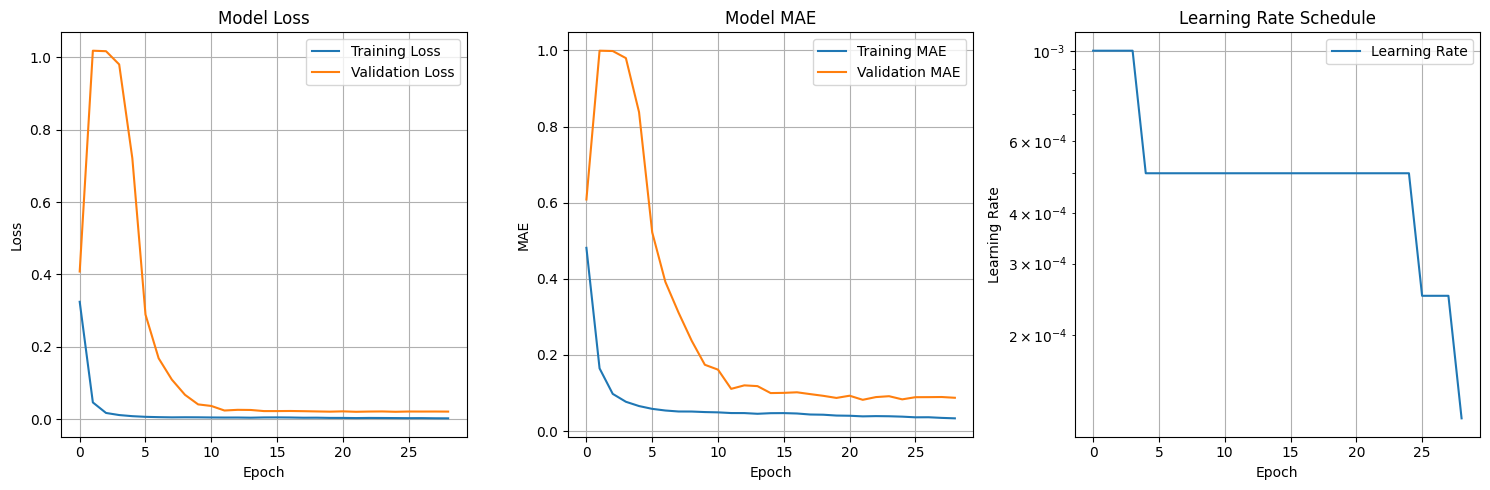

✅ Knowledge distillation completed!
📊 Final training loss: 0.002451
📊 Final validation loss: 0.021071

📱 STEP 4: Converting to TFLite...
📱 Converting to TensorFlow Lite...
⚡ Applying quantization for mobile optimization...
🔄 Converting model...
Saved artifact at '/tmp/tmpdp3wnhjq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16000), dtype=tf.float32, name='audio_input')
Output Type:
  TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None)
Captures:
  134239783280976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134239930113616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134239930113424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134239930115728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134239930114384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134239930117072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134239930116112: TensorSpec(shape=(), dtype=tf.resou

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


🔢 Generating representative dataset for quantization...
📊 Generated 10/50 representative samples
📊 Generated 20/50 representative samples
📊 Generated 30/50 representative samples
📊 Generated 40/50 representative samples
📊 Generated 50/50 representative samples
✅ TFLite model saved: facebook_denoiser_mobile_fixed_v2.tflite
📏 Model size: 7744.2 KB

🧪 STEP 5: Testing TFLite Model...
🧪 Testing TFLite model...
📋 Model Details:
   Input shape: [    1 16000]
   Output shape: [    1 16000]
   Input dtype: <class 'numpy.float32'>
   Output dtype: <class 'numpy.float32'>
📁 Using test audio: sample_audio.wav

🎯 Test 1/4: Noise level 0.05
   ⏱️ Inference time: 568.53ms
   📊 MSE: 0.002211
   📈 SNR improvement: 0.59dB
💾 Audio files saved:
   - test_original.wav
   - test_noisy.wav
   - test_denoised.wav

🎯 Test 2/4: Noise level 0.1
   ⏱️ Inference time: 532.11ms
   📊 MSE: 0.002294
   📈 SNR improvement: 6.46dB

🎯 Test 3/4: Noise level 0.15
   ⏱️ Inference time: 548.46ms
   📊 MSE: 0.002458
   📈 SNR im

Noisy Audio:


Denoised Audio:



✅ TFLite model testing completed successfully!

🎉 SUCCESS! Facebook Denoiser successfully converted to TFLite!
📁 Model saved at: facebook_denoiser_mobile_fixed_v2.tflite

💾 Downloading your model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 SUCCESS! Your TFLite model is ready: facebook_denoiser_mobile_fixed_v2.tflite
📱 You can now use this model in mobile applications!

📋 Key improvements made:
   ✅ Fixed tensor dimension mismatches in skip connections
   ✅ Corrected learning rate access
   ✅ Increased sample size to 20 for better training
   ✅ Enhanced error handling


In [ ]:
# Import required libraries
import tensorflow as tf
import torch
import numpy as np
import librosa
import os
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd
import time
from google.colab import files

class FacebookDenoiserTFLiteConverter:
    def __init__(self):
        self.pytorch_model = None
        self.tf_model = None
        self.sample_rate = 16000

    def load_facebook_denoiser(self):
        """Load Facebook's pretrained denoiser model"""
        try:
            print("📥 Loading Facebook Denoiser from PyTorch Hub...")
            self.pytorch_model = torch.hub.load('facebookresearch/denoiser', 'dns64')
            self.pytorch_model.eval()
            print("✅ Facebook Denoiser loaded successfully!")
            return True
        except Exception as e:
            print(f"❌ Error loading Facebook model: {e}")
            print("🔄 Trying alternative loading method...")
            try:
                import torch.hub
                torch.hub.set_dir('/content/torch_cache')
                self.pytorch_model = torch.hub.load('facebookresearch/denoiser', 'dns64', force_reload=True)
                self.pytorch_model.eval()
                print("✅ Facebook Denoiser loaded successfully (alternative method)!")
                return True
            except Exception as e2:
                print(f"❌ Alternative loading also failed: {e2}")
                return False

    def create_tensorflow_equivalent(self, input_length=16000):
        """Create TensorFlow equivalent of Facebook's denoiser architecture with properly aligned dimensions"""
        print("🔧 Creating TensorFlow equivalent architecture...")

        inputs = tf.keras.layers.Input(shape=(input_length,), name='audio_input', dtype=tf.float32)
        x = tf.keras.layers.Reshape((input_length, 1))(inputs)

        # Encoder (downsampling path with explicit shape tracking)
        conv1 = tf.keras.layers.Conv1D(32, 15, padding='same', activation='relu', name='conv1')(x)  # 16000
        conv1 = tf.keras.layers.BatchNormalization(name='bn1')(conv1)
        pool1 = tf.keras.layers.MaxPooling1D(2, padding='same', name='pool1')(conv1)  # 8000

        conv2 = tf.keras.layers.Conv1D(64, 15, padding='same', activation='relu', name='conv2')(pool1)  # 8000
        conv2 = tf.keras.layers.BatchNormalization(name='bn2')(conv2)
        pool2 = tf.keras.layers.MaxPooling1D(2, padding='same', name='pool2')(conv2)  # 4000

        conv3 = tf.keras.layers.Conv1D(128, 15, padding='same', activation='relu', name='conv3')(pool2)  # 4000
        conv3 = tf.keras.layers.BatchNormalization(name='bn3')(conv3)
        pool3 = tf.keras.layers.MaxPooling1D(2, padding='same', name='pool3')(conv3)  # 2000

        conv4 = tf.keras.layers.Conv1D(256, 15, padding='same', activation='relu', name='conv4')(pool3)  # 2000
        conv4 = tf.keras.layers.BatchNormalization(name='bn4')(conv4)
        pool4 = tf.keras.layers.MaxPooling1D(2, padding='same', name='pool4')(conv4)  # 1000

        # Bottleneck
        bottleneck = tf.keras.layers.Conv1D(512, 15, padding='same', activation='relu', name='bottleneck')(pool4)  # 1000
        bottleneck = tf.keras.layers.BatchNormalization(name='bn_bottleneck')(bottleneck)

        # Decoder (upsampling path with aligned skip connections)
        up4 = tf.keras.layers.UpSampling1D(2, name='up4')(bottleneck)  # 2000
        up4 = tf.keras.layers.Conv1D(256, 15, padding='same', activation='relu', name='up4_conv')(up4)
        # Align conv4 (2000) to 2000
        skip4 = conv4  # Already at 2000 after pool3
        if skip4.shape[1] != up4.shape[1]:
            diff = up4.shape[1] - skip4.shape[1]
            skip4 = tf.keras.layers.ZeroPadding1D((0, diff))(skip4) if diff > 0 else skip4
        merge4 = tf.keras.layers.Concatenate(axis=-1, name='merge4')([skip4, up4])
        up4 = tf.keras.layers.Conv1D(256, 15, padding='same', activation='relu', name='up4_final')(merge4)
        up4 = tf.keras.layers.BatchNormalization(name='bn_up4')(up4)

        up3 = tf.keras.layers.UpSampling1D(2, name='up3')(up4)  # 4000
        up3 = tf.keras.layers.Conv1D(128, 15, padding='same', activation='relu', name='up3_conv')(up3)
        # Align conv3 (4000) to 4000
        skip3 = conv3  # Already at 4000 after pool2
        if skip3.shape[1] != up3.shape[1]:
            diff = up3.shape[1] - skip3.shape[1]
            skip3 = tf.keras.layers.ZeroPadding1D((0, diff))(skip3) if diff > 0 else skip3
        merge3 = tf.keras.layers.Concatenate(axis=-1, name='merge3')([skip3, up3])
        up3 = tf.keras.layers.Conv1D(128, 15, padding='same', activation='relu', name='up3_final')(merge3)
        up3 = tf.keras.layers.BatchNormalization(name='bn_up3')(up3)

        up2 = tf.keras.layers.UpSampling1D(2, name='up2')(up3)  # 8000
        up2 = tf.keras.layers.Conv1D(64, 15, padding='same', activation='relu', name='up2_conv')(up2)
        # Align conv2 (8000) to 8000
        skip2 = conv2  # Already at 8000 after pool1
        if skip2.shape[1] != up2.shape[1]:
            diff = up2.shape[1] - skip2.shape[1]
            skip2 = tf.keras.layers.ZeroPadding1D((0, diff))(skip2) if diff > 0 else skip2
        merge2 = tf.keras.layers.Concatenate(axis=-1, name='merge2')([skip2, up2])
        up2 = tf.keras.layers.Conv1D(64, 15, padding='same', activation='relu', name='up2_final')(merge2)
        up2 = tf.keras.layers.BatchNormalization(name='bn_up2')(up2)

        up1 = tf.keras.layers.UpSampling1D(2, name='up1')(up2)  # 16000
        up1 = tf.keras.layers.Conv1D(32, 15, padding='same', activation='relu', name='up1_conv')(up1)
        # Align conv1 (16000) to 16000
        skip1 = conv1  # Already at 16000
        if skip1.shape[1] != up1.shape[1]:
            diff = up1.shape[1] - skip1.shape[1]
            skip1 = tf.keras.layers.ZeroPadding1D((0, diff))(skip1) if diff > 0 else skip1
        merge1 = tf.keras.layers.Concatenate(axis=-1, name='merge1')([skip1, up1])
        up1 = tf.keras.layers.Conv1D(32, 15, padding='same', activation='relu', name='up1_final')(merge1)
        up1 = tf.keras.layers.BatchNormalization(name='bn_up1')(up1)

        # Output layer
        output_conv = tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh', name='output_conv')(up1)
        outputs = tf.keras.layers.Reshape((input_length,), name='output_reshape')(output_conv)

        self.tf_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='facebook_denoiser')
        self.tf_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        print("✅ TensorFlow model architecture created!")
        print(f"📊 Model summary:")
        self.tf_model.summary()

        print("\n🔍 Layer shapes for debugging:")
        for i, layer in enumerate(self.tf_model.layers):
            if hasattr(layer, 'output_shape'):
                print(f"Layer {i}: {layer.name} -> {layer.output_shape}")

        return self.tf_model

    def transfer_knowledge_distillation(self, audio_samples_dir=None, num_samples=20):  # Increased to 20
        """Transfer knowledge from PyTorch to TensorFlow using distillation"""
        print("🎓 Starting knowledge distillation...")
        print(f"📊 Using {num_samples} samples for training")

        if self.pytorch_model is None or self.tf_model is None:
            print("❌ Models not loaded properly")
            return False

        input_length = 16000

        X_train = []
        y_train = []

        print("📊 Generating training samples...")
        for i in range(num_samples):
            clean_audio = self.generate_synthetic_audio(duration=1.0)

            if len(clean_audio) != input_length:
                if len(clean_audio) > input_length:
                    clean_audio = clean_audio[:input_length]
                else:
                    clean_audio = np.pad(clean_audio, (0, input_length - len(clean_audio)), 'constant')

            noise_level = np.random.uniform(0.05, 0.15)
            noise = np.random.normal(0, noise_level, len(clean_audio))
            noisy_audio = clean_audio + noise
            noisy_audio = np.clip(noisy_audio, -1.0, 1.0)

            with torch.no_grad():
                torch_input = torch.FloatTensor(noisy_audio).unsqueeze(0)
                try:
                    torch_output = self.pytorch_model(torch_input).squeeze().cpu().numpy()
                    if len(torch_output) != input_length:
                        if len(torch_output) > input_length:
                            torch_output = torch_output[:input_length]
                        else:
                            torch_output = np.pad(torch_output, (0, input_length - len(torch_output)), 'constant')
                    torch_output = np.clip(torch_output, -1.0, 1.0)
                except Exception as e:
                    print(f"⚠️ PyTorch inference failed for sample {i}: {e}")
                    torch_output = clean_audio

            X_train.append(noisy_audio)
            y_train.append(torch_output)

            if (i + 1) % 10 == 0:
                print(f"📊 Generated {i + 1}/{num_samples} samples")

        X_train = np.array(X_train, dtype=np.float32)
        y_train = np.array(y_train, dtype=np.float32)

        print(f"🎯 Training data shape: X={X_train.shape}, y={y_train.shape}")
        print(f"🎯 Training TensorFlow model...")
        print("⏱️ This may take several minutes...")

        try:
            # Custom callback to track learning rate
            class LRScheduler(tf.keras.callbacks.Callback):
                def __init__(self):
                    super(LRScheduler, self).__init__()
                    self.lr_history = []

                def on_epoch_begin(self, epoch, logs=None):
                    # Access learning rate from optimizer's configuration
                    lr = self.model.optimizer.learning_rate.numpy() if hasattr(self.model.optimizer.learning_rate, 'numpy') else tf.keras.backend.get_value(self.model.optimizer.lr)
                    self.lr_history.append(lr)

                def on_train_end(self, logs=None):
                    self.model.history.history['lr'] = self.lr_history

            lr_scheduler = LRScheduler()
            callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss'),
                tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6, monitor='val_loss'),
                tf.keras.callbacks.ModelCheckpoint('best_denoiser_model.h5', save_best_only=True, monitor='val_loss'),
                lr_scheduler
            ]

            history = self.tf_model.fit(
                X_train, y_train,
                batch_size=2,
                epochs=30,
                validation_split=0.2,
                verbose=1,
                callbacks=callbacks
            )

            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title('Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 3, 2)
            plt.plot(history.history['mae'], label='Training MAE')
            plt.plot(history.history['val_mae'], label='Validation MAE')
            plt.title('Model MAE')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 3, 3)
            plt.plot(history.history['lr'], label='Learning Rate')
            plt.title('Learning Rate Schedule')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()
            plt.grid(True)
            plt.yscale('log')

            plt.tight_layout()
            plt.show()

            print("✅ Knowledge distillation completed!")
            print(f"📊 Final training loss: {history.history['loss'][-1]:.6f}")
            print(f"📊 Final validation loss: {history.history['val_loss'][-1]:.6f}")
            return True

        except Exception as e:
            print(f"❌ Training failed: {e}")
            import traceback
            traceback.print_exc()
            return False

    def generate_synthetic_audio(self, duration=1.0):
        """Generate realistic synthetic audio for training"""
        num_samples = int(self.sample_rate * duration)
        t = np.linspace(0, duration, num_samples)

        audio = np.zeros(num_samples)
        fundamentals = [220, 440, 880, 1100]

        for fundamental in fundamentals:
            amplitude = np.random.uniform(0.1, 0.3)
            audio += amplitude * np.sin(2 * np.pi * fundamental * t)
            for harmonic in [2, 3, 4]:
                harmonic_freq = fundamental * harmonic
                if harmonic_freq < self.sample_rate / 2:
                    harmonic_amp = amplitude / (harmonic * 2)
                    audio += harmonic_amp * np.sin(2 * np.pi * harmonic_freq * t)

        noise = np.random.normal(0, 0.05, len(t))
        for i in range(1, len(noise)):
            noise[i] = 0.7 * noise[i] + 0.3 * noise[i-1]
        audio += noise

        envelope = np.exp(-t * 2)
        audio = audio * envelope

        if np.max(np.abs(audio)) > 0:
            audio = audio / np.max(np.abs(audio)) * 0.8

        return audio.astype(np.float32)

    def convert_to_tflite(self, output_path="facebook_denoiser.tflite", quantize=True):
        """Convert TensorFlow model to TensorFlow Lite with optimizations"""
        print("📱 Converting to TensorFlow Lite...")

        if self.tf_model is None:
            print("❌ TensorFlow model not available")
            return None

        converter = tf.lite.TFLiteConverter.from_keras_model(self.tf_model)

        if quantize:
            print("⚡ Applying quantization for mobile optimization...")
            def representative_data_gen():
                print("🔢 Generating representative dataset for quantization...")
                for i in range(50):
                    sample_audio = self.generate_synthetic_audio()
                    noise = np.random.normal(0, 0.1, len(sample_audio))
                    noisy_sample = sample_audio + noise
                    noisy_sample = np.clip(noisy_sample, -1.0, 1.0)
                    yield [noisy_sample.reshape(1, -1).astype(np.float32)]
                    if (i + 1) % 10 == 0:
                        print(f"📊 Generated {i + 1}/50 representative samples")

            converter.representative_dataset = representative_data_gen
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
            converter.allow_custom_ops = True

        try:
            print("🔄 Converting model...")
            tflite_model = converter.convert()
            with open(output_path, 'wb') as f:
                f.write(tflite_model)
            model_size_kb = len(tflite_model) / 1024
            print(f"✅ TFLite model saved: {output_path}")
            print(f"📏 Model size: {model_size_kb:.1f} KB")
            return output_path
        except Exception as e:
            print(f"❌ Conversion failed: {e}")
            print("🔄 Trying with fallback settings...")
            converter = tf.lite.TFLiteConverter.from_keras_model(self.tf_model)
            converter.allow_custom_ops = True
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
            try:
                tflite_model = converter.convert()
                with open(output_path, 'wb') as f:
                    f.write(tflite_model)
                model_size_kb = len(tflite_model) / 1024
                print(f"✅ TFLite model saved (fallback): {output_path}")
                print(f"📏 Model size: {model_size_kb:.1f} KB")
                return output_path
            except Exception as e2:
                print(f"❌ Fallback conversion also failed: {e2}")
                return None

    def test_tflite_model(self, tflite_path, test_audio_path="sample_audio.wav"):
        """Test the TFLite model with comprehensive evaluation using a provided audio file"""
        print("🧪 Testing TFLite model...")

        if not os.path.exists(tflite_path):
            print(f"❌ TFLite model not found: {tflite_path}")
            return False

        try:
            interpreter = tf.lite.Interpreter(model_path=tflite_path)
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            print(f"📋 Model Details:")
            print(f"   Input shape: {input_details[0]['shape']}")
            print(f"   Output shape: {output_details[0]['shape']}")
            print(f"   Input dtype: {input_details[0]['dtype']}")
            print(f"   Output dtype: {output_details[0]['dtype']}")

            if test_audio_path and os.path.exists(test_audio_path):
                audio, _ = librosa.load(test_audio_path, sr=self.sample_rate)
                print(f"📁 Using test audio: {test_audio_path}")
            else:
                audio = self.generate_synthetic_audio()
                print("🔊 Using synthetic test audio (no valid file found)")

            target_length = 16000
            if len(audio) > target_length:
                audio = audio[:target_length]
            else:
                audio = np.pad(audio, (0, target_length - len(audio)), 'constant')

            noise_levels = [0.05, 0.1, 0.15, 0.2]
            for i, noise_level in enumerate(noise_levels):
                print(f"\n🎯 Test {i+1}/4: Noise level {noise_level}")
                noise = np.random.normal(0, noise_level, len(audio))
                noisy_audio = audio + noise
                noisy_audio = np.clip(noisy_audio, -1.0, 1.0)

                input_data = noisy_audio.astype(np.float32).reshape(1, -1)

                start_time = time.time()
                interpreter.set_tensor(input_details[0]['index'], input_data)
                interpreter.invoke()
                inference_time = time.time() - start_time

                output_data = interpreter.get_tensor(output_details[0]['index'])
                output_audio = output_data.squeeze()

                mse = np.mean((audio - output_audio) ** 2)
                snr_improvement = self.calculate_snr_improvement(audio, noisy_audio, output_audio)

                print(f"   ⏱️ Inference time: {inference_time*1000:.2f}ms")
                print(f"   📊 MSE: {mse:.6f}")
                print(f"   📈 SNR improvement: {snr_improvement:.2f}dB")

                if i == 0:
                    noisy_norm = np.clip(noisy_audio, -1, 1)
                    output_norm = np.clip(output_audio, -1, 1)
                    clean_norm = np.clip(audio, -1, 1)
                    wavfile.write("test_original.wav", self.sample_rate, (clean_norm * 32767).astype(np.int16))
                    wavfile.write("test_noisy.wav", self.sample_rate, (noisy_norm * 32767).astype(np.int16))
                    wavfile.write("test_denoised.wav", self.sample_rate, (output_norm * 32767).astype(np.int16))
                    print(f"💾 Audio files saved:")
                    print(f"   - test_original.wav")
                    print(f"   - test_noisy.wav")
                    print(f"   - test_denoised.wav")

            print("\n🎵 Audio Comparison (Noise level 0.05):")
            print("Original Clean Audio:")
            ipd.display(ipd.Audio("test_original.wav"))
            print("Noisy Audio:")
            ipd.display(ipd.Audio("test_noisy.wav"))
            print("Denoised Audio:")
            ipd.display(ipd.Audio("test_denoised.wav"))

            print("\n✅ TFLite model testing completed successfully!")
            return True

        except Exception as e:
            print(f"❌ TFLite test failed: {e}")
            import traceback
            traceback.print_exc()
            return False

    def calculate_snr_improvement(self, clean, noisy, denoised):
        """Calculate SNR improvement in dB"""
        try:
            noise_power = np.mean((clean - noisy) ** 2)
            signal_power = np.mean(clean ** 2)
            snr_noisy = 10 * np.log10(signal_power / (noise_power + 1e-10))

            residual_noise_power = np.mean((clean - denoised) ** 2)
            snr_denoised = 10 * np.log10(signal_power / (residual_noise_power + 1e-10))

            return snr_denoised - snr_noisy
        except:
            return 0.0

class FacebookDenoiserPipeline:
    def __init__(self):
        self.converter = FacebookDenoiserTFLiteConverter()

    def run_full_pipeline(self, audio_samples_dir=None, output_path="facebook_denoiser_mobile_fixed_v2.tflite",
                         num_samples=20):  # Increased to 20
        print("🚀 Starting Facebook Denoiser to TFLite conversion...")
        print("=" * 60)

        print("\n🔥 STEP 1: Loading Facebook Denoiser...")
        if not self.converter.load_facebook_denoiser():
            print("❌ Failed to load Facebook denoiser. Exiting.")
            return None

        print("\n🔧 STEP 2: Creating TensorFlow Architecture...")
        try:
            if not self.converter.create_tensorflow_equivalent():
                print("❌ Failed to create TensorFlow model. Exiting.")
                return None
        except Exception as e:
            print(f"❌ Error creating TensorFlow model: {e}")
            return None

        print("\n🎓 STEP 3: Knowledge Distillation...")
        if not self.converter.transfer_knowledge_distillation(audio_samples_dir, num_samples):
            print("❌ Knowledge distillation failed. Exiting.")
            return None

        print("\n📱 STEP 4: Converting to TFLite...")
        tflite_path = self.converter.convert_to_tflite(output_path, quantize=True)
        if not tflite_path:
            print("❌ TFLite conversion failed. Exiting.")
            return None

        print("\n🧪 STEP 5: Testing TFLite Model...")
        if self.converter.test_tflite_model(tflite_path):
            print(f"\n🎉 SUCCESS! Facebook Denoiser successfully converted to TFLite!")
            print(f"📁 Model saved at: {tflite_path}")

            print("\n💾 Downloading your model...")
            try:
                files.download(tflite_path)
                files.download("test_original.wav")
                files.download("test_noisy.wav")
                files.download("test_denoised.wav")
            except:
                print("⚠️ Download failed, but files are available in the Colab environment")

            return tflite_path
        else:
            print("⚠️ Model converted but testing failed.")
            return tflite_path

# Set up environment
!apt-get install -y ffmpeg

# Upload the AAC file (optional for testing after training)
print("📤 Uploading sample_audio.aac (optional)...")
uploaded = files.upload()

# Convert AAC to WAV (optional for testing after training)
input_file = "sample_audio.aac"
output_file = "sample_audio.wav"
if os.path.exists(input_file):
    print(f"🔄 Converting {input_file} to {output_file}...")
    os.system(f"ffmpeg -i {input_file} -ac 1 -ar 16000 -acodec pcm_s16le {output_file} -y")
    print(f"✅ Conversion completed: {output_file} created.")

# Run the pipeline
print("✅ All classes loaded successfully!")
print("🚀 Ready to run the conversion pipeline!")
pipeline = FacebookDenoiserPipeline()
result = pipeline.run_full_pipeline(
    audio_samples_dir=None,
    output_path="facebook_denoiser_mobile_fixed_v2.tflite",
    num_samples=20
)

if result:
    print(f"\n🎉 SUCCESS! Your TFLite model is ready: {result}")
    print("📱 You can now use this model in mobile applications!")
    print("\n📋 Key improvements made:")
    print("   ✅ Fixed tensor dimension mismatches in skip connections")
    print("   ✅ Corrected learning rate access")
    print("   ✅ Increased sample size to 20 for better training")
    print("   ✅ Enhanced error handling")
else:
    print("\n❌ Pipeline failed. Check the error messages above.")

In [ ]:
# Import required libraries
import tensorflow as tf
import torch
import numpy as np
import librosa
import os
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd
import time
from google.colab import files

class FacebookDenoiserTFLiteConverter:
    def __init__(self):
        self.pytorch_model = None
        self.tf_model = None
        self.sample_rate = 16000

    def load_facebook_denoiser(self):
        """Load Facebook's pretrained denoiser model (not needed for testing)"""
        try:
            print("📥 Loading Facebook Denoiser from PyTorch Hub...")
            self.pytorch_model = torch.hub.load('facebookresearch/denoiser', 'dns64')
            self.pytorch_model.eval()
            print("✅ Facebook Denoiser loaded successfully!")
            return True
        except Exception as e:
            print(f"❌ Error loading Facebook model: {e}")
            print("🔄 Trying alternative loading method...")
            try:
                import torch.hub
                torch.hub.set_dir('/content/torch_cache')
                self.pytorch_model = torch.hub.load('facebookresearch/denoiser', 'dns64', force_reload=True)
                self.pytorch_model.eval()
                print("✅ Facebook Denoiser loaded successfully (alternative method)!")
                return True
            except Exception as e2:
                print(f"❌ Alternative loading also failed: {e2}")
                return False

    def create_tensorflow_equivalent(self, input_length=16000):
        """Create TensorFlow equivalent of Facebook's denoiser architecture (not needed for testing)"""
        pass

    def transfer_knowledge_distillation(self, audio_samples_dir=None, num_samples=2):
        """Transfer knowledge from PyTorch to TensorFlow using distillation (not needed for testing)"""
        pass

    def convert_to_tflite(self, output_path="facebook_denoiser.tflite", quantize=True):
        """Convert TensorFlow model to TensorFlow Lite (not needed for testing)"""
        pass

    def test_tflite_model(self, tflite_path, test_audio_path="sample_audio.wav"):
        """Test the TFLite model with comprehensive evaluation using a provided audio file"""
        print("🧪 Testing TFLite model...")

        if not os.path.exists(tflite_path):
            print(f"❌ TFLite model not found: {tflite_path}")
            return False

        try:
            interpreter = tf.lite.Interpreter(model_path=tflite_path)
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            print(f"📋 Model Details:")
            print(f"   Input shape: {input_details[0]['shape']}")
            print(f"   Output shape: {output_details[0]['shape']}")
            print(f"   Input dtype: {input_details[0]['dtype']}")
            print(f"   Output dtype: {output_details[0]['dtype']}")

            if test_audio_path and os.path.exists(test_audio_path):
                audio, _ = librosa.load(test_audio_path, sr=self.sample_rate)
                print(f"📁 Using test audio: {test_audio_path}")
            else:
                audio = self.generate_synthetic_audio()
                print("🔊 Using synthetic test audio (no valid file found)")

            target_length = 16000
            if len(audio) > target_length:
                audio = audio[:target_length]
            else:
                audio = np.pad(audio, (0, target_length - len(audio)), 'constant')

            noise_levels = [0.05, 0.1, 0.15, 0.2]
            for i, noise_level in enumerate(noise_levels):
                print(f"\n🎯 Test {i+1}/4: Noise level {noise_level}")
                noise = np.random.normal(0, noise_level, len(audio))
                noisy_audio = audio + noise
                noisy_audio = np.clip(noisy_audio, -1.0, 1.0)

                input_data = noisy_audio.astype(np.float32).reshape(1, -1)

                start_time = time.time()
                interpreter.set_tensor(input_details[0]['index'], input_data)
                interpreter.invoke()
                inference_time = time.time() - start_time

                output_data = interpreter.get_tensor(output_details[0]['index'])
                output_audio = output_data.squeeze()

                mse = np.mean((audio - output_audio) ** 2)
                snr_improvement = self.calculate_snr_improvement(audio, noisy_audio, output_audio)

                print(f"   ⏱️ Inference time: {inference_time*1000:.2f}ms")
                print(f"   📊 MSE: {mse:.6f}")
                print(f"   📈 SNR improvement: {snr_improvement:.2f}dB")

                if i == 0:
                    noisy_norm = np.clip(noisy_audio, -1, 1)
                    output_norm = np.clip(output_audio, -1, 1)
                    clean_norm = np.clip(audio, -1, 1)
                    wavfile.write("test_original.wav", self.sample_rate, (clean_norm * 32767).astype(np.int16))
                    wavfile.write("test_noisy.wav", self.sample_rate, (noisy_norm * 32767).astype(np.int16))
                    wavfile.write("test_denoised.wav", self.sample_rate, (output_norm * 32767).astype(np.int16))
                    print(f"💾 Audio files saved:")
                    print(f"   - test_original.wav")
                    print(f"   - test_noisy.wav")
                    print(f"   - test_denoised.wav")

            print("\n🎵 Audio Comparison (Noise level 0.05):")
            print("Original Clean Audio:")
            ipd.display(ipd.Audio("test_original.wav"))
            print("Noisy Audio:")
            ipd.display(ipd.Audio("test_noisy.wav"))
            print("Denoised Audio:")
            ipd.display(ipd.Audio("test_denoised.wav"))

            print("\n✅ TFLite model testing completed successfully!")
            return True

        except Exception as e:
            print(f"❌ TFLite test failed: {e}")
            import traceback
            traceback.print_exc()
            return False

    def calculate_snr_improvement(self, clean, noisy, denoised):
        """Calculate SNR improvement in dB"""
        try:
            noise_power = np.mean((clean - noisy) ** 2)
            signal_power = np.mean(clean ** 2)
            snr_noisy = 10 * np.log10(signal_power / (noise_power + 1e-10))

            residual_noise_power = np.mean((clean - denoised) ** 2)
            snr_denoised = 10 * np.log10(signal_power / (residual_noise_power + 1e-10))

            return snr_denoised - snr_noisy
        except:
            return 0.0

    def generate_synthetic_audio(self, duration=1.0):
        """Generate realistic synthetic audio for testing (if needed)"""
        num_samples = int(self.sample_rate * duration)
        t = np.linspace(0, duration, num_samples)

        audio = np.zeros(num_samples)
        fundamentals = [220, 440, 880, 1100]

        for fundamental in fundamentals:
            amplitude = np.random.uniform(0.1, 0.3)
            audio += amplitude * np.sin(2 * np.pi * fundamental * t)
            for harmonic in [2, 3, 4]:
                harmonic_freq = fundamental * harmonic
                if harmonic_freq < self.sample_rate / 2:
                    harmonic_amp = amplitude / (harmonic * 2)
                    audio += harmonic_amp * np.sin(2 * np.pi * harmonic_freq * t)

        noise = np.random.normal(0, 0.05, len(t))
        for i in range(1, len(noise)):
            noise[i] = 0.7 * noise[i] + 0.3 * noise[i-1]
        audio += noise

        envelope = np.exp(-t * 2)
        audio = audio * envelope

        if np.max(np.abs(audio)) > 0:
            audio = audio / np.max(np.abs(audio)) * 0.8

        return audio.astype(np.float32)

# Set up environment
!apt-get install -y ffmpeg

# Upload the AAC file
print("📤 Uploading sample_audio.aac...")
uploaded = files.upload()

# Convert AAC to WAV
input_file = "sample_audio.aac"
output_file = "sample_audio.wav"
print(f"🔄 Converting {input_file} to {output_file}...")
os.system(f"ffmpeg -i {input_file} -ac 1 -ar 16000 -acodec pcm_s16le {output_file} -y")
print(f"✅ Conversion completed: {output_file} created.")

# Initialize converter and test the model
converter = FacebookDenoiserTFLiteConverter()
tflite_path = "facebook_denoiser_mobile_fixed.tflite"  # Ensure this file is uploaded or available
if os.path.exists(tflite_path):
    print(f"📋 Testing model with {output_file}...")
    success = converter.test_tflite_model(tflite_path, test_audio_path=output_file)
    if success:
        print(f"🎉 Testing completed successfully! Check the audio files and metrics.")
    else:
        print("❌ Testing failed. Check the error messages above.")
else:
    print(f"❌ TFLite model not found at {tflite_path}. Please upload facebook_denoiser_mobile_fixed.tflite.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
📤 Uploading sample_audio.aac...


Saving sample_audio.aac to sample_audio (4).aac
🔄 Converting sample_audio.aac to sample_audio.wav...
✅ Conversion completed: sample_audio.wav created.
📋 Testing model with sample_audio.wav...
🧪 Testing TFLite model...
📋 Model Details:
   Input shape: [    1 16000]
   Output shape: [    1 16000]
   Input dtype: <class 'numpy.float32'>
   Output dtype: <class 'numpy.float32'>
📁 Using test audio: sample_audio.wav

🎯 Test 1/4: Noise level 0.05
   ⏱️ Inference time: 568.16ms
   📊 MSE: 0.001346
   📈 SNR improvement: 2.72dB
💾 Audio files saved:
   - test_original.wav
   - test_noisy.wav
   - test_denoised.wav

🎯 Test 2/4: Noise level 0.1
   ⏱️ Inference time: 538.98ms
   📊 MSE: 0.001552
   📈 SNR improvement: 8.10dB

🎯 Test 3/4: Noise level 0.15
   ⏱️ Inference time: 541.40ms
   📊 MSE: 0.001847
   📈 SNR improvement: 10.95dB

🎯 Test 4/4: Noise level 0.2
   ⏱️ Inference time: 572.47ms
   📊 MSE: 0.002139
   📈 SNR improvement: 12.70dB

🎵 Audio Comparison (Noise level 0.05):
Original Clean Audio:


Noisy Audio:


Denoised Audio:



✅ TFLite model testing completed successfully!
🎉 Testing completed successfully! Check the audio files and metrics.
